In [179]:
import warnings
warnings.filterwarnings("ignore")
from glob import glob
import pandas as pd

# Load Merged and Cleaned Data

In [180]:
AllData_df = pd.read_feather("../data/clean/CleanedData.feather")
AllData_df

,Date,avgKWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,...,weekday sin,weekday cos,month sin,month cos,Time of Year sin,Time of Year cos,year,season sin,season cos,(-1)volume weighted price
0,2011-11-25,9.499781,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,...,-0.433884,-0.900969,-0.500000,0.866025,-0.596943,0.802284,2011,1.224647e-16,-1.000000e+00,44.97
1,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,...,-0.974928,-0.222521,-0.500000,0.866025,-0.583054,0.812434,2011,1.224647e-16,-1.000000e+00,42.66
2,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,...,-0.781831,0.623490,-0.500000,0.866025,-0.568992,0.822343,2011,1.224647e-16,-1.000000e+00,41.20
3,2011-11-28,9.103382,5.0,0.0,15.0,13.9,6.7,0.2,0.0,102270.0,...,0.000000,1.000000,-0.500000,0.866025,-0.554762,0.832009,2011,1.224647e-16,-1.000000e+00,42.83
4,2011-11-29,9.274873,6.0,0.0,15.0,12.8,8.6,3.3,0.4,100960.0,...,0.781831,0.623490,-0.500000,0.866025,-0.540368,0.841429,2011,1.224647e-16,-1.000000e+00,46.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,2014-02-24,10.092758,4.0,4.4,82.0,10.7,10.9,6.8,3.2,100500.0,...,0.000000,1.000000,0.866025,0.500000,0.804377,0.594119,2014,-1.000000e+00,-1.836970e-16,38.19
823,2014-02-25,10.042841,5.0,2.0,60.0,11.8,9.4,8.1,2.6,100050.0,...,0.781831,0.623490,0.866025,0.500000,0.814478,0.580194,2014,-1.000000e+00,-1.836970e-16,42.81
824,2014-02-26,9.992153,1.0,7.7,111.0,12.0,7.4,2.9,2.8,101270.0,...,0.974928,-0.222521,0.866025,0.500000,0.824338,0.566097,2014,-1.000000e+00,-1.836970e-16,41.60
825,2014-02-27,10.045084,4.0,4.9,90.0,8.4,8.9,5.7,4.8,100700.0,...,0.433884,-0.900969,0.866025,0.500000,0.833954,0.551833,2014,-1.000000e+00,-1.836970e-16,47.71


In [181]:
AllData_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       827 non-null    datetime64[ns]
 1   avgKWH                     827 non-null    float64       
 2   cloud_cover                827 non-null    float64       
 3   sunshine                   827 non-null    float64       
 4   global_radiation           827 non-null    float64       
 5   max_temp                   827 non-null    float64       
 6   mean_temp                  827 non-null    float64       
 7   min_temp                   827 non-null    float64       
 8   precipitation              827 non-null    float64       
 9   pressure                   827 non-null    float64       
 10  snow_depth                 827 non-null    float64       
 11  days_elapsed               827 non-null    int64         
 12  (-1)avgK

# Test Train Split
For the test train split on time series data, we will use a rolling k fold

https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
```
Split 1: Train [1] Test [2]
Split 2: Train [1, 2] Test [3]
Split 3: Train [1, 2, 3] Test [4]
Split 4: Train [1, 2, 3, 4] Test [5]
Split 5: Train [1, 2, 3, 4, 5] Test [6]
```

In [182]:
AllData_df

,Date,avgKWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,...,weekday sin,weekday cos,month sin,month cos,Time of Year sin,Time of Year cos,year,season sin,season cos,(-1)volume weighted price
0,2011-11-25,9.499781,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,...,-0.433884,-0.900969,-0.500000,0.866025,-0.596943,0.802284,2011,1.224647e-16,-1.000000e+00,44.97
1,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,...,-0.974928,-0.222521,-0.500000,0.866025,-0.583054,0.812434,2011,1.224647e-16,-1.000000e+00,42.66
2,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,...,-0.781831,0.623490,-0.500000,0.866025,-0.568992,0.822343,2011,1.224647e-16,-1.000000e+00,41.20
3,2011-11-28,9.103382,5.0,0.0,15.0,13.9,6.7,0.2,0.0,102270.0,...,0.000000,1.000000,-0.500000,0.866025,-0.554762,0.832009,2011,1.224647e-16,-1.000000e+00,42.83
4,2011-11-29,9.274873,6.0,0.0,15.0,12.8,8.6,3.3,0.4,100960.0,...,0.781831,0.623490,-0.500000,0.866025,-0.540368,0.841429,2011,1.224647e-16,-1.000000e+00,46.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,2014-02-24,10.092758,4.0,4.4,82.0,10.7,10.9,6.8,3.2,100500.0,...,0.000000,1.000000,0.866025,0.500000,0.804377,0.594119,2014,-1.000000e+00,-1.836970e-16,38.19
823,2014-02-25,10.042841,5.0,2.0,60.0,11.8,9.4,8.1,2.6,100050.0,...,0.781831,0.623490,0.866025,0.500000,0.814478,0.580194,2014,-1.000000e+00,-1.836970e-16,42.81
824,2014-02-26,9.992153,1.0,7.7,111.0,12.0,7.4,2.9,2.8,101270.0,...,0.974928,-0.222521,0.866025,0.500000,0.824338,0.566097,2014,-1.000000e+00,-1.836970e-16,41.60
825,2014-02-27,10.045084,4.0,4.9,90.0,8.4,8.9,5.7,4.8,100700.0,...,0.433884,-0.900969,0.866025,0.500000,0.833954,0.551833,2014,-1.000000e+00,-1.836970e-16,47.71


<Axes: title={'center': 'Data Distrubtion by Date'}, xlabel='Date', ylabel='Count'>

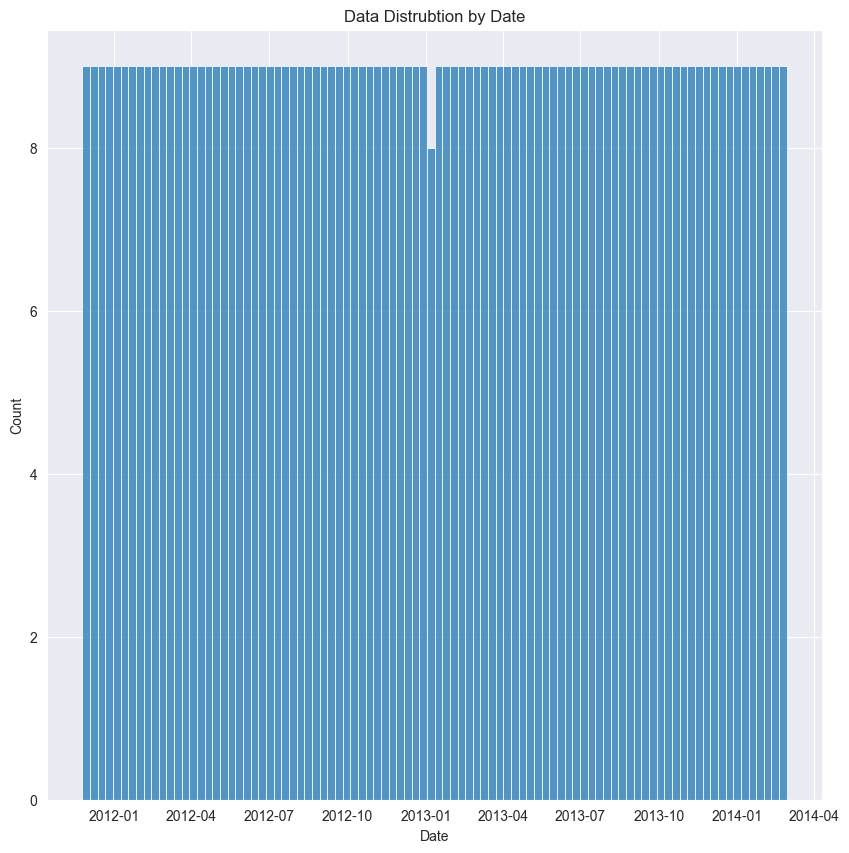

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title("Data Distrubtion by Date")
sns.histplot(AllData_df["Date"], bins=92)

In [184]:
# Split Data into 6 even segments.
SPLIT_COUNT = 6

splits = []
date_indexes = AllData_df["days_elapsed"]
AllData_df["DateIndex"] = date_indexes
data_length = len(date_indexes)
for i in range(SPLIT_COUNT):
    split = date_indexes[int(i * data_length / SPLIT_COUNT):int((i+1) * data_length / SPLIT_COUNT)]
    splits.append((split.min(), split.max()))
    if i != 0:
        if splits[i][0] == splits[i-1][1]:
            splits[i] = (splits[i][0] + 1, splits[i][1])

splits

[(0, 136), (137, 274), (275, 412), (413, 550), (551, 688), (689, 826)]

In [185]:
AllData_df["split"] = -1
for i, split in enumerate(splits):
    print(f"Split {i} has length: {len(AllData_df[(AllData_df['DateIndex'] >= split[0]) & (AllData_df['DateIndex'] <= split[1])].index )}")
    AllData_df.loc[(AllData_df["DateIndex"] >= split[0]) & (AllData_df["DateIndex"] <= split[1]), "split"] = i

Split 0 has length: 137
Split 1 has length: 138
Split 2 has length: 138
Split 3 has length: 138
Split 4 has length: 138
Split 5 has length: 138


<Axes: title={'center': '6 Folds for Test Train Split'}, xlabel='DateIndex', ylabel='Count'>

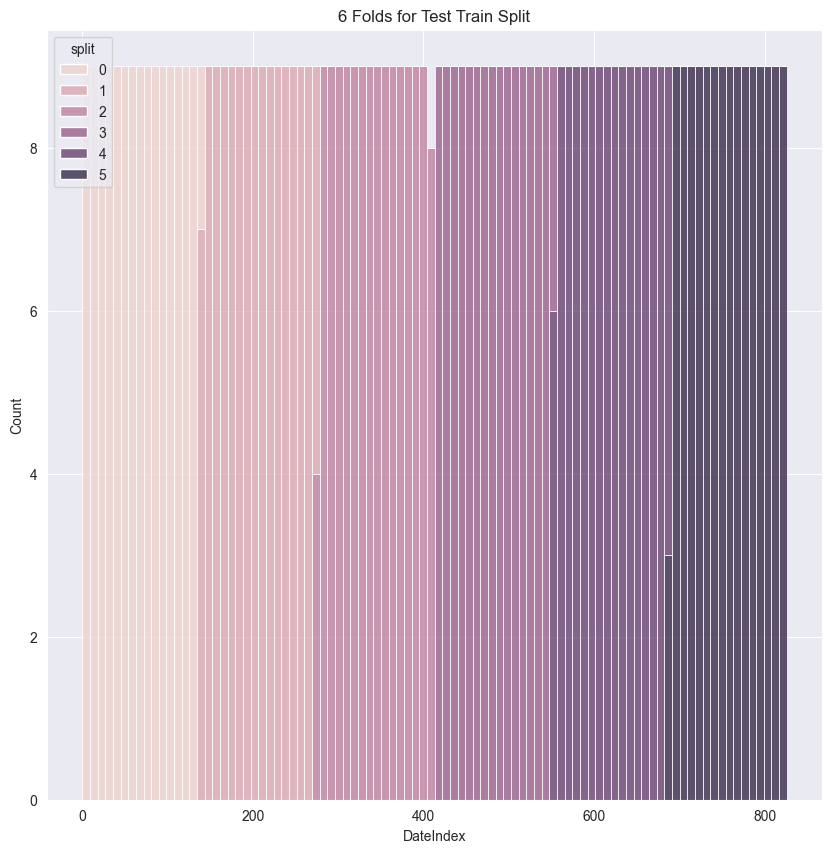

In [186]:
plt.figure(figsize=(10,10))
plt.title("6 Folds for Test Train Split")
sns.histplot(data=AllData_df, x="DateIndex", hue="split", multiple="stack", bins=92)

In [187]:
import os
os.makedirs("../data/test_train_split", exist_ok=True)

for i in range(len(splits) - 1):
    train_df = AllData_df[AllData_df["split"] <= i]
    train_df = train_df.drop(["DateIndex", "split"], axis=1)
    print(f"Train {i} has length {len(train_df.index)}")
    train_df.to_feather(f"../data/test_train_split/train_{i}.feather")

    test_df = AllData_df[AllData_df["split"] == i+1]
    test_df = test_df.drop(["DateIndex", "split"], axis=1)
    print(f"Test {i} has length {len(test_df.index)}")
    test_df.to_feather(f"../data/test_train_split/test_{i}.feather")

Train 0 has length 137
Test 0 has length 138
Train 1 has length 275
Test 1 has length 138
Train 2 has length 413
Test 2 has length 138
Train 3 has length 551
Test 3 has length 138
Train 4 has length 689
Test 4 has length 138
